# NPB-Omer Whole genome lifted over analysis at 5/10/25 kb resolution
Red - at 5kb resolution<br>
Magenta - at 25kb resolution
### 1. Generating .bedpe file
#### Dividing the NPB genome into 500kb windows (250 kb step size)
Excluding the inversions on chr04/06/08, deletion on chr03

In [6]:
cat /scratch/ak8725/NPB_new/NPB.genome

chr01	43270923
chr02	35937250
chr03	36413819
chr04	35502694
chr05	29958434
chr06	31248787
chr07	29697621
chr08	28443022
chr09	23012720
chr10	23207287
chr11	29021106
chr12	27531856


In [57]:
cat /scratch/ak8725/omer_mrg/omer.genome

chr01	42804815
chr02	37283348
chr03	40595595
chr04	34272791
chr05	30045131
chr06	31576741
chr07	30507914
chr08	29018812
chr09	23643651
chr10	24084775
chr11	29168041
chr12	26254206


In [2]:
#generating bed file with window coordinates from NPB excluding the large inv on chr06
# Define excluded regions

excluded_regions = {
    'chr03': (14412722, 19546404),
    'chr04': (8308641, 11571420),
    'chr06': (13165645, 17609896),
    'chr08': (14330528, 16788836)
}

# Define window size and step size
window_size = 500000  # 500 kb
step_size = 250000    # 250 kb

# Read genome sizes from file
genome_sizes = {}
with open('/scratch/ak8725/NPB_new/NPB.genome', 'r') as genome_file:
    for line in genome_file:
        chromosome, size = line.strip().split('\t')
        genome_sizes[chromosome] = int(size)

# Generate BED coordinates
bed_coordinates = []
for chromosome, size in genome_sizes.items():
    if chromosome in excluded_regions:
        start, end = excluded_regions[chromosome]
        if end - start >= window_size:
            for window_start in range(0, start, step_size):
                window_end = window_start + window_size
                if window_end <= start:
                    bed_coordinates.append((chromosome, window_start, window_end))
        
        # Continue generating windows after excluded region
        for window_start in range(end, size - window_size + 1, step_size):
            window_end = window_start + window_size
            bed_coordinates.append((chromosome, window_start, window_end))
        continue
    
    for window_start in range(0, size - window_size + 1, step_size):
        window_end = window_start + window_size
        bed_coordinates.append((chromosome, window_start, window_end))

# Write coordinates to BED file
with open('NPB-Omer.bed', 'w') as bed_file:
    for chromosome, start, end in bed_coordinates:
        bed_file.write(f'{chromosome}\t{start}\t{end}\n')

In [1]:
excluded_regions = {
    'chr03': (14412722, 19546404),
    'chr04': (8308641, 11571420),
    'chr06': (13165645, 17609896),
    'chr08': (14330528, 16788836)
}

total_length = 0

# Iterate through the excluded regions and calculate the total length
for start, end in excluded_regions.values():
    total_length += end - start

print("Total length of excluded regions:", total_length)

Total length of excluded regions: 15299020


In [4]:
#lifting over coordinates from NPB to Omer
#could've tried -minMatch=0.2 option to lift over more windows
!/share/apps/kent/385/liftOver -ends=1 ./NPB-Omer/NPB-Omer.bed  ../../../liftOver/chain_files/NPB_omer.over.chain NPB-Omer_conv.bed unMapped

Can't find file: ./NPB-Omer/NPB-Omer.bed



Out of 1408 intervals, 1059 are not converted which is 2118/2/1408 = 75%

In [6]:
#deleting windows from NPB that were not lifted over to IR64
# Read the unMapped_starts file and store the coordinates to remove
coordinates_to_remove = set()
with open("unMapped", "r") as unMapped_file:
    for line in unMapped_file:
        if not line.startswith("#"):
            chromosome, start, end = line.strip().split("\t")
            coordinates_to_remove.add((chromosome, start, end))

# Read the NPB-Az.bed file and write the filtered coordinates to a new file
with open("NPB-Omer.bed", "r") as bed_file, open("NPB-Omer_filtered.bed", "w") as filtered_file:
    for line in bed_file:
        chromosome, start, end = line.strip().split()
        if (chromosome, start, end) not in coordinates_to_remove:
            filtered_file.write(f"{chromosome}\t{start}\t{end}\n")

In [7]:
!wc -l NPB-Omer.bed #number of windows in NPB
!wc -l NPB-Omer_conv.bed #number of windows that were lifted over to Azucena, should be equal to:
!wc -l NPB-Omer_filtered.bed #number of windows in NPB after filtering out those that were not lifted over
!wc -l unMapped #windows not lifted over (divide by 2)

1408 NPB-Omer.bed
349 NPB-Omer_conv.bed
349 NPB-Omer_filtered.bed
2118 unMapped


### Generating .bedpe file with only 25% of windows

In [8]:
#Generating .bedpe file with NPB and Az pairs
#col1,2,3 - coordinates in NPB
#col4,5,6 - coordinates in Omer
with open("NPB-Omer_filtered.bed", "r") as filtered_file, \
     open("NPB-Omer_conv.bed", "r") as conv_file, \
     open("NPB-Omer_pairs.bedpe", "w") as pairs_file:
    for row_num, (filtered_line, conv_line) in enumerate(zip(filtered_file, conv_file), start=1):
        filtered_parts = filtered_line.strip().split("\t")
        conv_parts = conv_line.strip().split("\t")
        
        if len(filtered_parts) >= 3 and len(conv_parts) >= 3:
            col1, col2, col3 = filtered_parts
            col4, col5, col6 = conv_parts[:3]
            
            pairs_file.write(f"{col1}\t{col2}\t{col3}\t{col4}\t{col5}\t{col6}\t{row_num}\t.\t+\t+\n")

# Generate random pairs

In [1]:
import os
import pandas as pd
from pathlib import Path 

original_pair_file_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer.bedpe'
random_pair_files_folder_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/random_pairs'

df = pd.read_csv(original_pair_file_path, sep='\t', header=None)
for index in range(1, 101):
  df_permute = pd.DataFrame({0:df[3], 1:df[4], 2:df[5]})
  df_permute = df_permute.sample(frac = 1)
  df_permute.reset_index(inplace=True)

  df_random = pd.DataFrame({'chromosomes1': df[0],
                          'region_start1': df[1],
                          'region_end1': df[2],
                          'chromosomes2': df_permute[0],
                          'random_start2': df_permute[1],
                          'random_end2': df_permute[2],
                          'pair_id': df[6],
                          'dot': df[7],
                          'strand1': df[8],
                          'strand2': df[9]})

  df_random.to_csv(f'{random_pair_files_folder_path}/{Path(original_pair_file_path).stem}_random_gen_{index}.bedpe', sep='\t', index=False, header=False)


### 3. CHESS at 25kb, SN >= 0.5 plotted

/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Total number of ssim values: 349
Number of rows with SN >= 0.5: 253


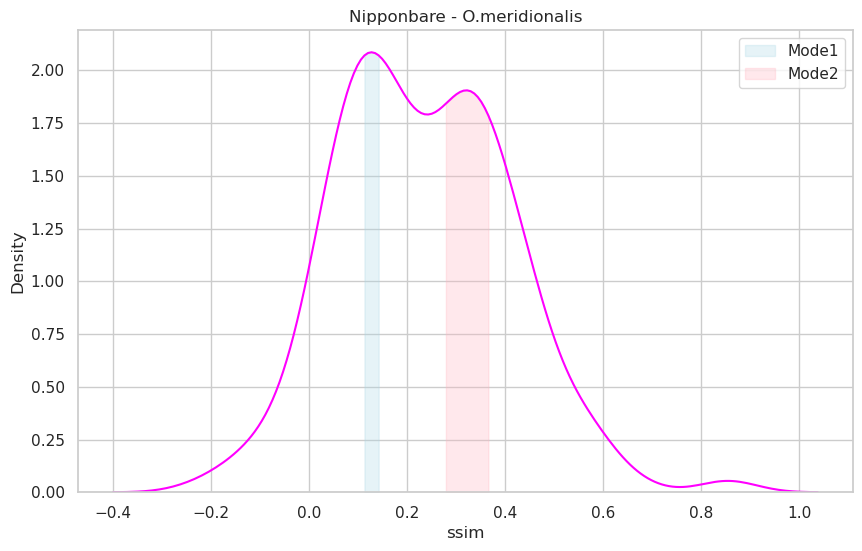

In [3]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

results_folder_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25_NPB_ref/NPB-Omer/results'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'NPB-Omer-25%.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()
final_df_filtered = final_df_filtered[final_df_filtered['type'] == 'experiment'].copy()

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()
plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('Nipponbare - O.meridionalis')

#shade the modes
kde_x, kde_y = plot.get_lines()[0].get_data()
plt.fill_between(kde_x, kde_y, where=(kde_x >= 0.10805272) & (kde_x <= 0.14618896), alpha=0.3,  color='lightblue')
plt.fill_between(kde_x, kde_y, where=(kde_x >= 0.27201077) & (kde_x <= 0.36801459), alpha=0.3, color='lightpink')

# Add a legend specifying that 'Mode1' is shaded with lavenderblush
custom_handles = [
    plt.Rectangle((0, 0), 1, 1, color='lightblue', alpha=0.3, label='Mode1'),
    plt.Rectangle((0, 0), 1, 1, color='lightpink', alpha=0.3, label='Mode2')
]

plt.legend(handles=custom_handles, labels=labels + ['Mode1', 'Mode2'])

output_file_path = '/scratch/ak8725/figs/fig7A.pdf'
plt.savefig(output_file_path)

# Count rows with type 'experiment'
total = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", total)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5:", experiment_rows_count)

#### Finding the modes of the experimental values and average random values mode

In [43]:
import numpy as np
import scipy.stats as stats
import pandas as pd

# Assuming 'final_df_filtered' is your DataFrame

# Create a list to collect mode values for random_{index}
random_modes = []

# Variables to store mode for 'experiment'
experiment_mode = None

# Find mode for each density plot
for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['z_ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value

# Calculate the average mode for 'random_{index}'
if random_modes:
    average_random_mode = np.mean(random_modes)
    print(f"Average Mode of the density plots for 'random_{{index}}': {average_random_mode}")
else:
    print("No valid data found for 'random_{index}'")

# Print the mode for 'experiment'
if experiment_mode is not None:
    print(f"Mode of the density plot for 'experiment': {experiment_mode}")
else:
    print("No valid data found for 'experiment'")

Average Mode of the density plots for 'random_{index}': -0.13651724507759616
Mode of the density plot for 'experiment': 0.32424412636901545


### Finding the two modes. All SSIM values plotted

Modes: [0.12603106 0.32001268 0.85400704]


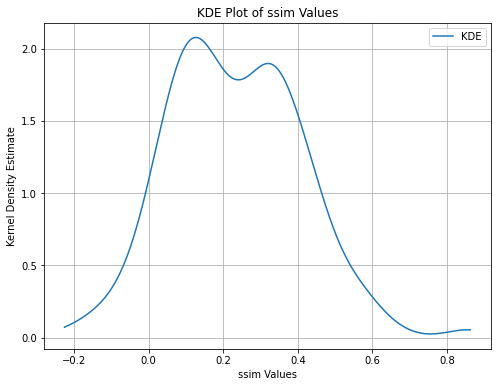

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Load data from the TSV file
file_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/results/NPB-Omer-25%.tsv'
df = pd.read_csv(file_path, sep='\t')

# Extract the 'ssim' column and remove NaN values
ssim_data = df['ssim'].dropna()

# Create the KDE plot
kde = stats.gaussian_kde(ssim_data)

# Define a range of values to evaluate the KDE
x_values = np.linspace(ssim_data.min(), ssim_data.max(), 1000)

# Evaluate the KDE at the specified values
kde_values = kde(x_values)

# Find local maxima in the KDE values
local_maxima_indices = np.where((kde_values[:-2] < kde_values[1:-1]) & (kde_values[2:] < kde_values[1:-1]))[0] + 1

# Retrieve the values corresponding to the modes
modes = x_values[local_maxima_indices]

# Create the KDE plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, kde_values, label='KDE')
plt.xlabel('ssim Values')
plt.ylabel('Kernel Density Estimate')
plt.title('KDE Plot of ssim Values')
plt.legend()
plt.grid(True)

# Print the modes
print("Modes:", modes)

# Show the KDE plot
plt.show()


### Finding the two modes. SSIM with SN >= 0.5 values plotted

Modes: [0.12712084 0.32001268 0.85400704]


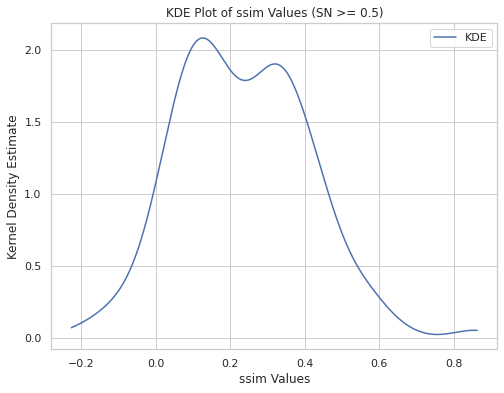

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Load data from the TSV file
file_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/results/NPB-Omer-25%.tsv'
df = pd.read_csv(file_path, sep='\t')

# Filter the DataFrame to include only rows where 'SN' >= 0.5 and extract 'ssim' column
filtered_df = df[df['SN'] >= 0.5]
ssim_data = filtered_df['ssim'].dropna()

# Create the KDE plot
kde = stats.gaussian_kde(ssim_data)

# Define a range of values to evaluate the KDE
x_values = np.linspace(ssim_data.min(), ssim_data.max(), 1000)

# Evaluate the KDE at the specified values
kde_values = kde(x_values)

# Find local maxima in the KDE values
local_maxima_indices = np.where((kde_values[:-2] < kde_values[1:-1]) & (kde_values[2:] < kde_values[1:-1]))[0] + 1

# Retrieve the values corresponding to the modes
modes = x_values[local_maxima_indices]

# Create the KDE plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, kde_values, label='KDE')
plt.xlabel('ssim Values')
plt.ylabel('Kernel Density Estimate')
plt.title('KDE Plot of ssim Values (SN >= 0.5)')
plt.legend()
plt.grid(True)

# Print the modes
print("Modes:", modes)

# Show the KDE plot
plt.show()

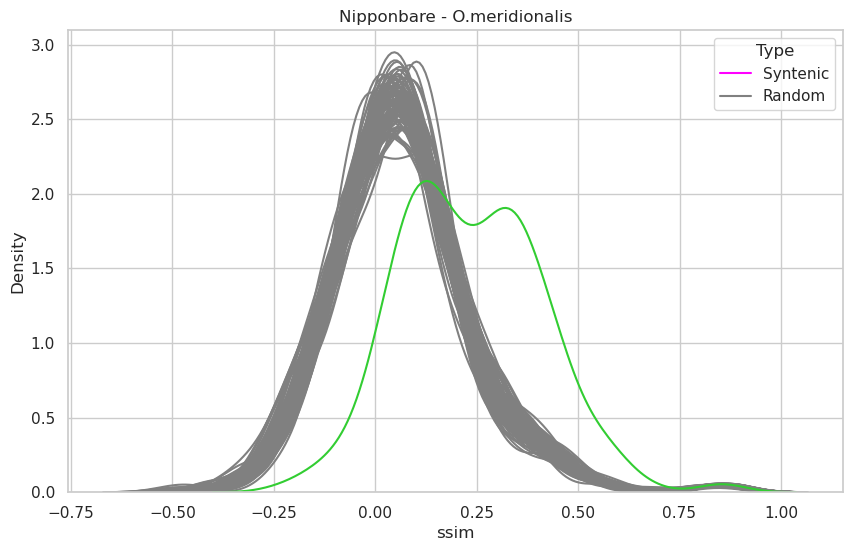

Total number of ssim values: 349
Number of rows with SN >= 0.5: 253
Mode of the density plot: 0.13


In [4]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

results_folder_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/results'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'NPB-Omer-25%.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'limegreen' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)
handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]
custom_labels = ['Syntenic', 'Random']

plt.legend(custom_handles, custom_labels, title='Type')

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('Nipponbare - O.meridionalis')
plt.show()

# Count rows with type 'experiment'
total = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", total)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5:", experiment_rows_count)

#calculate mode of experiment
# Create a list to collect mode values for random_{index}
random_modes = []

# Variables to store mode for 'experiment'
experiment_mode = None

# Find mode for each density plot
for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")

# Extracting windows with SSIM around the two modes (+- 15%)

In [41]:
#mode1  [0.10805272, 0.14618896]

import pandas as pd

# Define the file paths
input_file_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/results/NPB-Omer-25%.tsv'
output_file_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1.tsv'

# Read the data from the input file into a DataFrame
df = pd.read_csv(input_file_path, sep='\t')

# Define the lower and upper bounds for the 'ssim' range
lower_bound = 0.10805272
upper_bound = 0.14618896

# Filter rows based on conditions
filtered_df = df[(df['SN'] >= 0.5) & (df['ssim'] >= lower_bound) & (df['ssim'] <= upper_bound)]

# Save the filtered data to a new file
filtered_df.to_csv(output_file_path, sep='\t', index=False)

In [42]:
#mode2 [0.27201077, 0.36801459]

import pandas as pd

# Define the file paths
input_file_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/results/NPB-Omer-25%.tsv'
output_file_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2.tsv'

# Read the data from the input file into a DataFrame
df = pd.read_csv(input_file_path, sep='\t')

# Define the lower and upper bounds for the 'ssim' range
lower_bound = 0.27201077
upper_bound = 0.36801459

# Filter rows based on conditions
filtered_df = df[(df['SN'] >= 0.5) & (df['ssim'] >= lower_bound) & (df['ssim'] <= upper_bound)]

# Save the filtered data to a new file
filtered_df.to_csv(output_file_path, sep='\t', index=False)

In [12]:
#creating .bed files with coordinates of NPB windows corresponding to windows from mode1.tsv
# Define the file paths
bedpe_file = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer.bedpe'
tsv_file = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1.tsv'
output_bed_file = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1.bed'

# Create a set to store the ID numbers from mode2.tsv
tsv_ids = set()
with open(tsv_file, 'r') as tsv:
    next(tsv)  # Skip the header
    for line in tsv:
        parts = line.strip().split('\t')
        tsv_ids.add(int(parts[0]))

# Create the mode2.bed file
with open(output_bed_file, 'w') as output_bed:
    with open(bedpe_file, 'r') as bedpe:
        for line in bedpe:
            parts = line.strip().split('\t')
            bedpe_id = int(parts[6])
            if bedpe_id in tsv_ids:
                output_bed.write('\t'.join(parts[:3]) + '\n')

print(f'{output_bed_file} created successfully.')

/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1.bed created successfully.


In [44]:
#creating .bed files with coordinates of NPB windows corresponding to windows from mode2.tsv
# Define the file paths
bedpe_file = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer.bedpe'
tsv_file = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1.tsv'
output_bed_file = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1.bed'

# Create a set to store the ID numbers from mode2.tsv
tsv_ids = set()
with open(tsv_file, 'r') as tsv:
    next(tsv)  # Skip the header
    for line in tsv:
        parts = line.strip().split('\t')
        tsv_ids.add(int(parts[0]))

# Create the mode2.bed file
with open(output_bed_file, 'w') as output_bed:
    with open(bedpe_file, 'r') as bedpe:
        for line in bedpe:
            parts = line.strip().split('\t')
            bedpe_id = int(parts[6])
            if bedpe_id in tsv_ids:
                output_bed.write('\t'.join(parts[:3]) + '\n')

print(f'{output_bed_file} created successfully.')

/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1.bed created successfully.


# Analyzing distribution of different features between mode1 and mode2 windows

In [136]:
#deleting the non-chr
!sed -i '/^GU592207\.1/d' /scratch/ak8725/az_mrg/fitcons/from_zoe/H3K4me3.bedgraph

In [4]:
ls /scratch/ak8725/npb_feature_tracks/

npb_GC_content_per_500bp.bedgraph  npb_inv_per_500bp.bedgraph
npb_copia_per_500bp.bedgraph       npb_line_per_500bp.bedgraph
npb_del_per_500bp.bedgraph         npb_rest_retro_te_per_500bp.bedgraph
npb_dna_te_per_500bp.bedgraph      npb_sine_per_500bp.bedgraph
npb_dup_per_500bp.bedgraph         npb_snp_per_500bp.bedgraph
npb_genes_per_500bp.bedgraph       npb_sv_per_500bp.bedgraph
npb_gypsy_per_500bp.bedgraph       npb_te_per_500bp.bedgraph
npb_ins_per_500bp.bedgraph


In [3]:
ls /scratch/ak8725/az_mrg/fitcons/from_zoe/

H3K18ac.bedgraph   H3K27me3.bw        PhastCons8wayChrAll.bedgraph*
H3K18ac.bw         H3K4me3.bedgraph   methylation_from_zoe.bedgraph*
H3K27ac.bedgraph   H3K4me3.bw         methylation_from_zoe.bw
H3K27ac.bw         PRO-seq.bedgraph*  rho.bedgraph
H3K27me3.bedgraph  PRO-seq.bw         rho.bw


In [24]:
#making file tab-delimited
!sed -i -e 's/\s/\t/g' /scratch/ak8725/npb_feature_tracks/npb_rest_retro_te_per_500bp.bedgraph

In [46]:
from pybedtools import BedTool
import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/')

# Create a dictionary to store BedTool objects with their names as keys
bedtools_dict = {
    'pro': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PRO-seq.bedgraph'),
    'meth': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/methylation_from_zoe.bedgraph'),
    'H3K18ac': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K18ac.bedgraph'),
    'H3K27ac': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K27ac.bedgraph'),
    'H3K27me3': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K27me3.bedgraph'),
    'H3K4me3': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K4me3.bedgraph'),
    'rho': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/rho.bedgraph'),
    'phast': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PhastCons8wayChrAll.bedgraph'),
    'genes': BedTool('/scratch/ak8725/npb_feature_tracks/npb_genes_per_500bp.bedgraph'),
    'gc': BedTool('/scratch/ak8725/npb_feature_tracks/npb_GC_content_per_500bp.bedgraph'),
    'sv': BedTool('/scratch/ak8725/npb_feature_tracks/npb_sv_per_500bp.bedgraph'),
    'snp': BedTool('/scratch/ak8725/npb_feature_tracks/npb_snp_per_500bp.bedgraph'),
    'te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_te_per_500bp.bedgraph'),
    'dna_te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_dna_te_per_500bp.bedgraph'),
    'gypsy': BedTool('/scratch/ak8725/npb_feature_tracks/npb_gypsy_per_500bp.bedgraph'),
    'copia': BedTool('/scratch/ak8725/npb_feature_tracks/npb_copia_per_500bp.bedgraph'),
    'line': BedTool('/scratch/ak8725/npb_feature_tracks/npb_line_per_500bp.bedgraph'),
    'sine': BedTool('/scratch/ak8725/npb_feature_tracks/npb_sine_per_500bp.bedgraph'),
    'rest_retro_te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_rest_retro_te_per_500bp.bedgraph'),
    'ssd': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PRO-seq.bedgraph'),
    'wgd': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/methylation_from_zoe.bedgraph'),
    'tips': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_per_500bp.bedgraph'),
    'tips_del': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_del_per_500bp.bedgraph'),
    'tips_ins': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_ins_per_500bp.bedgraph'),
    'exp': BedTool('/scratch/ak8725/expression/Nip_field2017_Normal.bed')
}

mode1 = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed')
mode2 = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed')

# Define the list of output file names
output_files = [
    'mode1.txt',
    'mode2.txt'
]

#calculating mean feature value per mode
for obj_name, obj in bedtools_dict.items():
    for output_file in output_files:
        output_name = f'{obj_name}_{output_file}'  # Generate output file name based on object name and output file type
        
        # Use mode1 and mode2 BedTool objects instead of obj
        if "mode1" in output_name:
            result = mode1.map(obj, c=4, o='mean', output=output_name)
        elif "mode2" in output_name:
            result = mode2.map(obj, c=4, o='mean', output=output_name)
        
        print(f'Mean {obj_name} per window calculated, output saved as {output_name}')

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean pro per window calculated, output saved as pro_mode1.txt
Mean pro per window calculated, output saved as pro_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000



Mean meth per window calculated, output saved as meth_mode1.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean meth per window calculated, output saved as meth_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000



Mean H3K18ac per window calculated, output saved as H3K18ac_mode1.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean H3K18ac per window calculated, output saved as H3K18ac_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000



Mean H3K27ac per window calculated, output saved as H3K27ac_mode1.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean H3K27ac per window calculated, output saved as H3K27ac_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000



Mean H3K27me3 per window calculated, output saved as H3K27me3_mode1.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean H3K27me3 per window calculated, output saved as H3K27me3_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000



Mean H3K4me3 per window calculated, output saved as H3K4me3_mode1.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean H3K4me3 per window calculated, output saved as H3K4me3_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000



Mean rho per window calculated, output saved as rho_mode1.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean rho per window calculated, output saved as rho_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000



Mean phast per window calculated, output saved as phast_mode1.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean phast per window calculated, output saved as phast_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean genes per window calculated, output saved as genes_mode1.txt
Mean genes per window calculated, output saved as genes_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean gc per window calculated, output saved as gc_mode1.txt
Mean gc per window calculated, output saved as gc_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean sv per window calculated, output saved as sv_mode1.txt
Mean sv per window calculated, output saved as sv_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean snp per window calculated, output saved as snp_mode1.txt
Mean snp per window calculated, output saved as snp_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean te per window calculated, output saved as te_mode1.txt
Mean te per window calculated, output saved as te_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean dna_te per window calculated, output saved as dna_te_mode1.txt
Mean dna_te per window calculated, output saved as dna_te_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean gypsy per window calculated, output saved as gypsy_mode1.txt
Mean gypsy per window calculated, output saved as gypsy_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean copia per window calculated, output saved as copia_mode1.txt
Mean copia per window calculated, output saved as copia_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean line per window calculated, output saved as line_mode1.txt
Mean line per window calculated, output saved as line_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean sine per window calculated, output saved as sine_mode1.txt
Mean sine per window calculated, output saved as sine_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean rest_retro_te per window calculated, output saved as rest_retro_te_mode1.txt
Mean rest_retro_te per window calculated, output saved as rest_retro_te_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean ssd per window calculated, output saved as ssd_mode1.txt
Mean ssd per window calculated, output saved as ssd_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000



Mean wgd per window calculated, output saved as wgd_mode1.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean wgd per window calculated, output saved as wgd_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean tips per window calculated, output saved as tips_mode1.txt
Mean tips per window calculated, output saved as tips_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean tips_del per window calculated, output saved as tips_del_mode1.txt
Mean tips_del per window calculated, output saved as tips_del_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean tips_ins per window calculated, output saved as tips_ins_mode1.txt
Mean tips_ins per window calculated, output saved as tips_ins_mode2.txt
Mean exp per window calculated, output saved as exp_mode1.txt
Mean exp per window calculated, output saved as exp_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



In [47]:
#compare the values in col4 between two groups without assuming that they have the same means
#using a two-sample non-parametric test, such as the Mann-Whitney U test (also known as the Wilcoxon rank-sum test)
#This test compares whether there is a significant difference in the distributions of the values between the two groups
import pandas as pd
from scipy import stats

# Initialize an empty list to store p-values
p_values = []

# Iterate through the BedTool objects in bedtools_dict
for key, obj in bedtools_dict.items():
    # Generate the output file names for mode1 and mode2 based on the key
    mode1_file = f'{key}_mode1.txt'
    mode2_file = f'{key}_mode2.txt'
        
    # Perform the Mann-Whitney U test for mode1 and mode2
    mode1_data = pd.read_csv(mode1_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    mode2_data = pd.read_csv(mode2_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    
    # Convert 'value' column to numeric, handling errors with 'coerce' to replace non-numeric values with NaN
    mode1_data['value'] = pd.to_numeric(mode1_data['value'], errors='coerce')
    mode2_data['value'] = pd.to_numeric(mode2_data['value'], errors='coerce')
    
    # Drop rows with NaN values in 'value' column
    mode1_data = mode1_data.dropna(subset=['value'])
    mode2_data = mode2_data.dropna(subset=['value'])
    
    u_statistic, p_value = stats.mannwhitneyu(mode1_data['value'], mode2_data['value'], alternative='two-sided')
    
    # Append the p-value to the p_values list
    p_values.append((key, p_value))

# Print the list of p-values
for key, p_value in p_values:
    print(f'P-value for {key}: {p_value}')

P-value for pro: 0.14287718749271516
P-value for meth: 0.01340056939842946
P-value for H3K18ac: 0.681171485081693
P-value for H3K27ac: 0.008988753145705816
P-value for H3K27me3: 0.041467900653299965
P-value for H3K4me3: 0.026089761564300925
P-value for rho: 0.0059820005884024105
P-value for phast: 0.005448899931937312
P-value for genes: 0.0020437763341079394
P-value for gc: 0.36488131404191804
P-value for sv: 0.13360939655116397
P-value for snp: 0.0017511483454436913
P-value for te: 0.0008764344581730682
P-value for dna_te: 0.2202347585707377
P-value for gypsy: 0.0010887060029517927
P-value for copia: 0.004959064587705295
P-value for line: 0.6753717177441612
P-value for sine: 0.031169880393762426
P-value for rest_retro_te: 0.06315840886471374
P-value for ssd: 0.14287718749271516
P-value for wgd: 0.01340056939842946
P-value for tips: 0.6423089071828507
P-value for tips_del: 0.6423089071828507
P-value for tips_ins: 0.0002705810703740029
P-value for exp: 0.798088563417038


In [49]:
#compare the similarity scores between mode1 and mode2

import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/')

import pandas as pd
from scipy import stats

# Load the data from similarity_mode1.txt and similarity_mode2.txt into DataFrames
mode1_data = pd.read_csv('similarity_mode1.txt', sep='\t', header=None, names=['seq1', 'seq2', 'value'])
mode2_data = pd.read_csv('similarity_mode2.txt', sep='\t', header=None, names=['seq1', 'seq2', 'value'])

# Extract the values from the 'value' column of each group
group1_values = mode1_data['value']
group2_values = mode2_data['value']

# Perform the Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(group1_values, group2_values, alternative='two-sided')

# Calculate the sample sizes
n1 = len(group1_values)
n2 = len(group2_values)

# Calculate the effect size (rank-biserial correlation coefficient)
effect_size = u_statistic / (n1 * n2)
# Print the results
print(f'P-value for sequence similarity: {p_value}')
print(f'Effect size (rank-biserial correlation coefficient): {effect_size}')

P-value for sequence similarity: 0.0003549923913137395
Effect size (rank-biserial correlation coefficient): 0.2002551020408163


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of file pairs and their corresponding p-values
file_pairs = [
    {'key': 'ss', 'p-value': 0.0003},
    {'key': 'pro', 'p-value': 0.143},
    {'key': 'meth', 'p-value': 0.0134}, 
    {'key': 'H3K18ac', 'p-value': 0.681},
    {'key': 'H3K27ac', 'p-value': 0.009},
    {'key': 'H3K27me3', 'p-value': 0.041},
    {'key': 'H3K4me3', 'p-value': 0.026},
    {'key': 'rho', 'p-value': 0.006},
    {'key': 'phast', 'p-value': 0.005},
    {'key': 'genes', 'p-value': 0.002},
    {'key': 'gc', 'p-value': 0.345},
    {'key': 'sv', 'p-value': 0.134},
    {'key': 'snp', 'p-value': 0.002},
    {'key': 'te', 'p-value': 0.0009},
    {'key': 'dna_te', 'p-value': 0.22},
    {'key': 'gypsy', 'p-value': 0.001},
    {'key': 'copia', 'p-value': 0.005},
    {'key': 'line', 'p-value': 0.675},
    {'key': 'sine', 'p-value': 0.031},
    {'key': 'rest_retro_te', 'p-value': 0.063},
    {'key': 'ssd', 'p-value': 0.143},
    {'key': 'wgd', 'p-value': 0.013},
    {'key': 'tips', 'p-value': 0.642},
    {'key': 'tips_del', 'p-value': 0.642},
    {'key': 'tips_ins', 'p-value': 0.0003},
    {'key': 'exp', 'p-value': 0.798}
]

# Set the directory where your files are located
data_dir = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/'

# Loop through each file pair and create a box plot
for pair in file_pairs:
    key = pair['key']
    p_value = pair['p-value']

    # Load data from files into DataFrames
    mode1_file = os.path.join(data_dir, f'{key}_mode1.txt')
    mode2_file = os.path.join(data_dir, f'{key}_mode2.txt')
    
    # Check the number of columns in the file and read accordingly
    if len(pd.read_csv(mode1_file, sep='\t', header=None).columns) == 2:
        mode1_data = pd.read_csv(mode1_file, sep='\t', header=None, names=['start', 'col4'])
    else:
        mode1_data = pd.read_csv(mode1_file, sep='\t', header=None, names=['chr', 'start', 'end', 'col4'])

    if len(pd.read_csv(mode2_file, sep='\t', header=None).columns) == 2:
        mode2_data = pd.read_csv(mode2_file, sep='\t', header=None, names=['start', 'col4'])
    else:
        mode2_data = pd.read_csv(mode2_file, sep='\t', header=None, names=['chr', 'start', 'end', 'col4'])

    # Convert 'col4' to numeric, handling errors with 'coerce' to replace non-numeric values with NaN
    mode1_data['col4'] = pd.to_numeric(mode1_data['col4'], errors='coerce')
    mode2_data['col4'] = pd.to_numeric(mode2_data['col4'], errors='coerce')

    # Remove rows with NaN values in 'col4'
    mode1_data = mode1_data.dropna(subset=['col4'])
    mode2_data = mode2_data.dropna(subset=['col4'])

    # Create a combined DataFrame for both groups
    combined_data = pd.concat([mode1_data, mode2_data], keys=['1', '2'])

    # Create transparent box plots with customized colors
    plt.figure(figsize=(10, 6))

    # Define custom colors for the box plots and points
    boxplot_colors = ['lightblue', 'lightpink']
    point_colors = 'black'

    # Create box plots with custom colors
    b = sns.boxplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', width=0.4, fliersize=0,
                palette=boxplot_colors)

    # Customize the plot
    plt.xlabel('Mode')
    plt.ylabel('')
    
    sns.despine(offset=5, trim=True)
    b.set_title(f"p-value = {p_value:.4f}", fontsize=16)  # Use the p-value from the file_pairs list

    # Manually add labels to box plots
    ax = plt.gca()

    plt.tight_layout
    plt.savefig(f'{key}.png', dpi = 400, bbox_inches='tight')
    plt.close()

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/ss_mode1.txt'

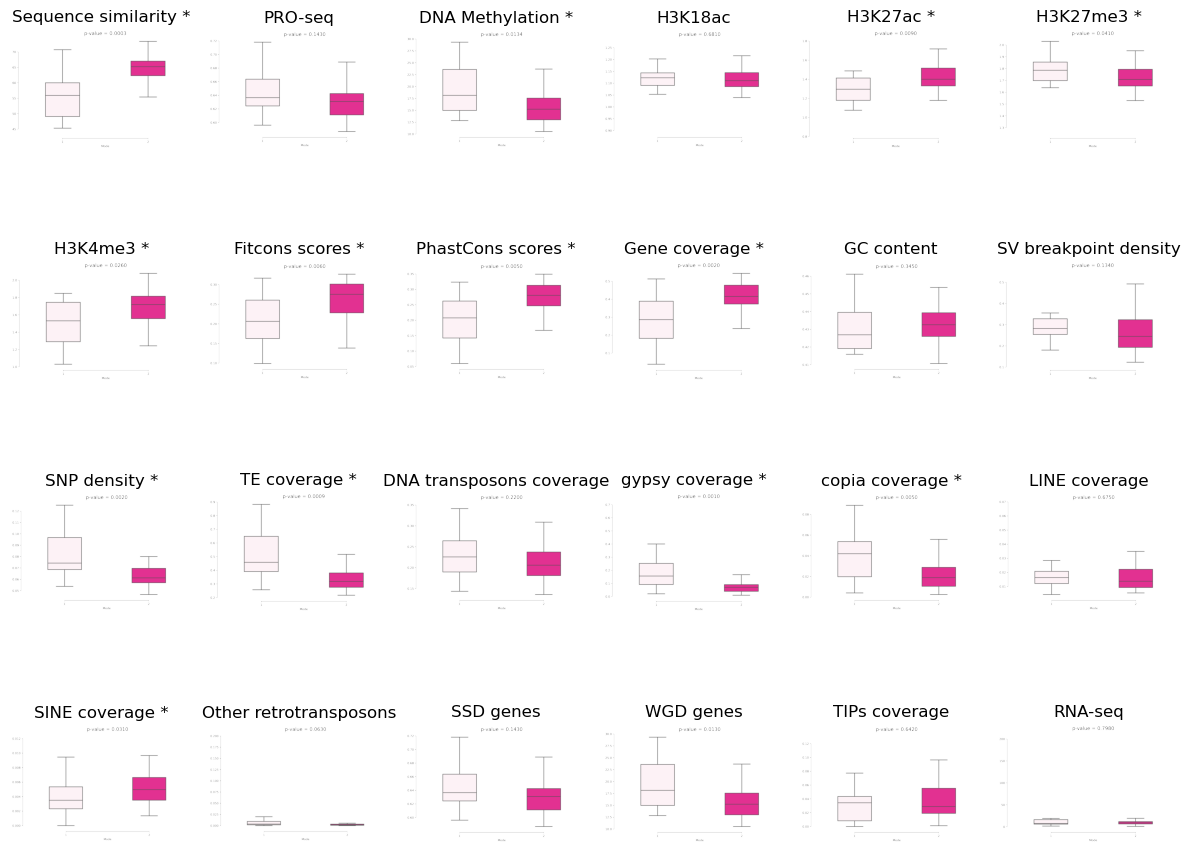

In [1]:
#combining png, plotting without tips_del and tips_ins
import os
import matplotlib.pyplot as plt
import math

# Directory containing your .png files
png_dir = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/'

# Define the order and titles for each image
image_order = [
    {'filename': 'ss.png', 'title': 'Sequence similarity'},
    {'filename': 'pro.png', 'title': 'PRO-seq'},
    {'filename': 'meth.png', 'title': 'DNA Methylation'},
    {'filename': 'H3K18ac.png', 'title': 'H3K18ac'},
    {'filename': 'H3K27ac.png', 'title': 'H3K27ac'},
    {'filename': 'H3K27me3.png', 'title': 'H3K27me3'},
    {'filename': 'H3K4me3.png', 'title': 'H3K4me3'},
    {'filename': 'rho.png', 'title': 'Fitcons scores'},
    {'filename': 'phast.png', 'title': 'PhastCons scores'},
    {'filename': 'genes.png', 'title': 'Gene coverage'},
    {'filename': 'gc.png', 'title': 'GC content'},
    {'filename': 'sv.png', 'title': 'SV breakpoint density'},
    {'filename': 'snp.png', 'title': 'SNP density'},
    {'filename': 'te.png', 'title': 'TE coverage'},
    {'filename': 'dna_te.png', 'title': 'DNA transposons coverage'},
    {'filename': 'gypsy.png', 'title': 'gypsy coverage'},
    {'filename': 'copia.png', 'title': 'copia coverage'},
    {'filename': 'line.png', 'title': 'LINE coverage'},
    {'filename': 'sine.png', 'title': 'SINE coverage'},
    {'filename': 'rest_retro_te.png', 'title': 'Other retrotransposons'},
    {'filename': 'ssd.png', 'title': 'SSD genes'},
    {'filename': 'wgd.png', 'title': 'WGD genes'},
    {'filename': 'tips.png', 'title': 'TIPs coverage'},
    {'filename': 'exp.png', 'title': 'RNA-seq'},
]

# Specify the filenames where you want to add an asterisk
filenames_with_asterisk = ['ss.png', 'snp.png', 'sine.png', 'rho.png', 'phast.png', 'genes.png', 'gypsy.png', 'copia.png', 'te.png', 'ss.png', 'meth.png', 'H3K27ac.png', 'H3K4me3.png', 'H3K27me3.png']

# Create a dictionary to map filenames to image_info dictionaries
image_info_dict = {entry['filename']: entry for entry in image_order}

# List of filenames sorted in the desired order
sorted_filenames = [
    'ss.png', 'pro.png', 'meth.png', 'H3K18ac.png', 'H3K27ac.png', 'H3K27me3.png',
    'H3K4me3.png', 'rho.png', 'phast.png', 'genes.png', 'gc.png',
    'sv.png', 'snp.png', 'te.png', 'dna_te.png', 'gypsy.png', 'copia.png',
    'line.png', 'sine.png', 'rest_retro_te.png', 'ssd.png', 'wgd.png', 
    'tips.png', 'exp.png'
]

# Calculate the number of rows and columns in the grid based on the number of images
num_images = len(sorted_filenames)
num_cols = 6
num_rows = math.ceil(num_images / num_cols)

# Create a new figure for the combined image
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10), facecolor='white')

# Iterate through the list of filenames and plot images in the specified order
for i, filename in enumerate(sorted_filenames):
    row = i // num_cols
    col = i % num_cols
    img = plt.imread(os.path.join(png_dir, filename))
    
    # Plot the image on the corresponding subplot
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # Turn off axis labels and ticks
    
    # Add an asterisk to the title if the filename is in filenames_with_asterisk
    image_info = image_info_dict.get(filename, {})
    title = image_info.get("title", "")
    if filename in filenames_with_asterisk:
        title = f"{title} *"
    
    # Add the title with the optional asterisk
    axes[row, col].set_title(title)

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined image
output_filename = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/NPB-Omer_modes.png'
plt.savefig(output_filename, dpi=300)

# Show the combined image (optional)
plt.show()
plt.close()

# Number of SSD and WGD derived genes per window

In [ ]:
#SSD/WGD gene enrichment could be due to overall gene enrichment of mode2
#need to control for gene enrichment and compare duplicatred gene enrichment
#also need to control for sequence similarity and compare all the features

# Number of TIPs (insertion/deletion) per window
TIPs data from Raul Castanera<br>
NPB and Omer genomes were aligned and ins/del of TEs in the Omer genome were mapped to NPB genome<br>
TE insertions are present in Nipponbare, but the coordinates are also Nipponbare

In [30]:
!head /scratch/ak8725/SV-TIPs_from_Raúl_Castanera/SV_TIPs/Omer_TIPs.bed

chr01	28721	28993	Os0018_Wanderer;MITE/Tourist	Deletion	+
chr01	29279	29541	Os0297;DNAnona/MULE	Deletion	-
chr01	30291	30685	Os0348;DNAnona/MULE	Deletion	-
chr01	34521	34753	Os3327;MITE/Stow	Deletion	+
chr01	36249	36255	Os0086;DNAnona/MULE	Insertion	+
chr01	41392	42226	RufipogonTE_00004098;DNA/DTM	Deletion	+
chr01	43170	58357	Os0030_INT_RIRE2-int;LTR/Gypsy	Deletion	-
chr01	135647	137462	Os0310_LTR;LTR/Gypsy	Deletion	-
chr01	149128	149133	Os2066_LTR;LTR/TRIM	Insertion	-
chr01	156633	164481	Os0988_INT-int;LTR/Copia	Deletion	-


In [19]:
!bedtools intersect -a /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed -b /scratch/ak8725/SV-TIPs_from_Raúl_Castanera/SV_TIPs/Omer_TIPs.bed -c > tips_mode1.txt
!bedtools intersect -a /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed -b /scratch/ak8725/SV-TIPs_from_Raúl_Castanera/SV_TIPs/Omer_TIPs.bed -c > tips_mode2.txt

***** WARNING: File /scratch/ak8725/SV-TIPs_from_Raúl_Castanera/SV_TIPs/Omer_TIPs.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	23315	38327	Os0253_INT-int;LTR/Copia	Deletion	-

***** WARNING: File /scratch/ak8725/SV-TIPs_from_Raúl_Castanera/SV_TIPs/Omer_TIPs.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	23315	38327	Os0253_INT-int;LTR/Copia	Deletion	-

***** WARNING: File /scratch/ak8725/SV-TIPs_from_Raúl_Castanera/SV_TIPs/Omer_TIPs.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	23315	38327	Os0253_INT-int;LTR/Copia	Deletion	-

***** WARNING: File /scratch/ak8725/SV-TIPs_from_Raúl_Castanera/SV_TIPs/Omer_TIPs.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	23315	38327	Os0253_INT-int;LTR/Copia	Deletion	-



# TIPs coverage (all,ins,del) per 500bp

In [80]:
!sed -i -e 's/\s/\t/g' /scratch/ak8725/npb_feature_tracks/omer_tips_per_500bp.bedgraph
!sed -i -e 's/\s/\t/g' /scratch/ak8725/npb_feature_tracks/omer_tips_del_per_500bp.bedgraph
!sed -i -e 's/\s/\t/g' /scratch/ak8725/npb_feature_tracks/omer_tips_ins_per_500bp.bedgraph

# Calculating sequence similarity

In [50]:
#filtered out regions >=1Mb, see Filtering regions.ipynb
!wc -l /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bedpe
!wc -l /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bedpe

16 /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bedpe
49 /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bedpe


In [3]:
#create fasta files with the mode sequences from npb and omer to compare them
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

# Paths to genome FASTA files
npb_genome_file = "/scratch/ak8725/NPB_new/NPB.fna"
omer_genome_file = "/scratch/ak8725/genomes/omer.fna"

# Path to bedpe file
bedpe_file = "/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bedpe"

# Output FASTA files
output_npb_file = "/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_npb.fasta"
output_omer_file = "/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_omer.fasta"

# Create dictionaries to store genome sequences
npb_sequences = SeqIO.to_dict(SeqIO.parse(npb_genome_file, "fasta"))
omer_sequences = SeqIO.to_dict(SeqIO.parse(omer_genome_file, "fasta"))

# Open the bedpe file for reading
with open(bedpe_file, "r") as bedpe_fh:

    # Open output files for writing
    with open(output_npb_file, "w") as npb_fh, open(output_omer_file, "w") as omer_fh:

        # Initialize a counter for sequence headers
        seq_counter = 1

        for line in bedpe_fh:
            fields = line.strip().split("\t")
            chr_npb, start_npb, end_npb, chr_omer, start_omer, end_omer = fields[:6]

            # Extract sequences from the dictionaries
            npb_seq = npb_sequences[chr_npb][int(start_npb):int(end_npb)].seq
            omer_seq = omer_sequences[chr_omer][int(start_omer):int(end_omer)].seq

            # Create SeqRecord objects with headers
            npb_record = SeqRecord(npb_seq, id=f"seq{seq_counter}", description=f"Coordinates: {chr_npb}:{start_npb}-{end_npb}")
            omer_record = SeqRecord(omer_seq, id=f"seq{seq_counter}", description=f"Coordinates: {chr_omer}:{start_omer}-{end_omer}")

            # Write SeqRecord objects to the output files
            SeqIO.write(npb_record, npb_fh, "fasta")
            SeqIO.write(omer_record, omer_fh, "fasta")

            # Increment the sequence counter
            seq_counter += 1

print("FASTA sequences extracted and saved to output files.")

FASTA sequences extracted and saved to output files.


In [ ]:
# Paiwise alignments of windows with emboss stretcher (global alignment)
# using stretcher.sh
# Output:
# /ss_mode1.txt
# /ss_mode2.txt

## NPB TAD coverage comparison between modes 

In [2]:
from pybedtools import BedTool
import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/')

# Create a dictionary to store BedTool objects with their names as keys
bedtools_dict = {
    'tads': BedTool('/scratch/ak8725/npb_feature_tracks/tads_per_500bp.bedgraph'),
}

mode1 = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed')
mode2 = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed')

# Define the list of output file names
output_files = [
    'mode1.txt',
    'mode2.txt'
]

#calculating mean feature value per mode
for obj_name, obj in bedtools_dict.items():
    for output_file in output_files:
        output_name = f'{obj_name}_{output_file}'  # Generate output file name based on object name and output file type
        
        # Use mode1 and mode2 BedTool objects instead of obj
        if "mode1" in output_name:
            result = mode1.map(obj, c=4, o='mean', output=output_name)
        elif "mode2" in output_name:
            result = mode2.map(obj, c=4, o='mean', output=output_name)
        
        print(f'Mean {obj_name} per window calculated, output saved as {output_name}')

Mean tads per window calculated, output saved as tads_mode1.txt
Mean tads per window calculated, output saved as tads_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



In [3]:
#compare the values in col4 between two groups without assuming that they have the same means
#using a two-sample non-parametric test, such as the Mann-Whitney U test (also known as the Wilcoxon rank-sum test)
#This test compares whether there is a significant difference in the distributions of the values between the two groups
import pandas as pd
from scipy import stats

# Initialize an empty list to store p-values
p_values = []

# Iterate through the BedTool objects in bedtools_dict
for key, obj in bedtools_dict.items():
    # Generate the output file names for mode1 and mode2 based on the key
    mode1_file = f'{key}_mode1.txt'
    mode2_file = f'{key}_mode2.txt'
        
    # Perform the Mann-Whitney U test for mode1 and mode2
    mode1_data = pd.read_csv(mode1_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    mode2_data = pd.read_csv(mode2_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    
    # Convert 'value' column to numeric, handling errors with 'coerce' to replace non-numeric values with NaN
    mode1_data['value'] = pd.to_numeric(mode1_data['value'], errors='coerce')
    mode2_data['value'] = pd.to_numeric(mode2_data['value'], errors='coerce')
    
    # Drop rows with NaN values in 'value' column
    mode1_data = mode1_data.dropna(subset=['value'])
    mode2_data = mode2_data.dropna(subset=['value'])
    
    u_statistic, p_value = stats.mannwhitneyu(mode1_data['value'], mode2_data['value'], alternative='two-sided')
    
    # Append the p-value to the p_values list
    p_values.append((key, p_value))

# Print the list of p-values
for key, p_value in p_values:
    print(f'P-value for {key}: {p_value}')

P-value for tads: 0.8967372568167593


# Mappability of windows
Calculated in /scratch/ak8725/genmap/npb_mappability2.bedgraph<br>
Is not different between modes

In [1]:
from pybedtools import BedTool
import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/')

# Create a dictionary to store BedTool objects with their names as keys
bedtools_dict = {
    'ms': BedTool('/scratch/ak8725/genmap/npb_mappability2.bedgraph'),
}

mode1 = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed')
mode2 = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed')

# Define the list of output file names
output_files = [
    'mode1.txt',
    'mode2.txt'
]

#calculating mean feature value per mode
for obj_name, obj in bedtools_dict.items():
    for output_file in output_files:
        output_name = f'{obj_name}_{output_file}'  # Generate output file name based on object name and output file type
        
        # Use mode1 and mode2 BedTool objects instead of obj
        if "mode1" in output_name:
            result = mode1.map(obj, c=4, o='mean', output=output_name)
        elif "mode2" in output_name:
            result = mode2.map(obj, c=4, o='mean', output=output_name)
        
        print(f'Mean {obj_name} per window calculated, output saved as {output_name}')

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode1_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	13000000	13500000



Mean ms per window calculated, output saved as ms_mode1.txt
Mean ms per window calculated, output saved as ms_mode2.txt


***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/mode2_filtered.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



In [2]:
#compare the values in col4 between two groups without assuming that they have the same means
#using a two-sample non-parametric test, such as the Mann-Whitney U test (also known as the Wilcoxon rank-sum test)
#This test compares whether there is a significant difference in the distributions of the values between the two groups
import pandas as pd
from scipy import stats

# Initialize an empty list to store p-values
p_values = []

# Iterate through the BedTool objects in bedtools_dict
for key, obj in bedtools_dict.items():
    # Generate the output file names for mode1 and mode2 based on the key
    mode1_file = f'{key}_mode1.txt'
    mode2_file = f'{key}_mode2.txt'
        
    # Perform the Mann-Whitney U test for mode1 and mode2
    mode1_data = pd.read_csv(mode1_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    mode2_data = pd.read_csv(mode2_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    
    # Convert 'value' column to numeric, handling errors with 'coerce' to replace non-numeric values with NaN
    mode1_data['value'] = pd.to_numeric(mode1_data['value'], errors='coerce')
    mode2_data['value'] = pd.to_numeric(mode2_data['value'], errors='coerce')
    
    # Drop rows with NaN values in 'value' column
    mode1_data = mode1_data.dropna(subset=['value'])
    mode2_data = mode2_data.dropna(subset=['value'])
    
    u_statistic, p_value = stats.mannwhitneyu(mode1_data['value'], mode2_data['value'], alternative='two-sided')
    
    # Append the p-value to the p_values list
    p_values.append((key, p_value))

# Print the list of p-values
for key, p_value in p_values:
    print(f'P-value for {key}: {p_value}')

P-value for ms: 0.09540823491459394


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of file pairs and their corresponding p-values
file_pairs = [
    {'key': 'ms', 'p-value': 0.095}
]

# Set the directory where your files are located
data_dir = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/'

# Loop through each file pair and create a box plot
for pair in file_pairs:
    key = pair['key']
    p_value = pair['p-value']

    # Load data from files into DataFrames
    mode1_file = os.path.join(data_dir, f'{key}_mode1.txt')
    mode2_file = os.path.join(data_dir, f'{key}_mode2.txt')
    
    # Check the number of columns in the file and read accordingly
    if len(pd.read_csv(mode1_file, sep='\t', header=None).columns) == 2:
        mode1_data = pd.read_csv(mode1_file, sep='\t', header=None, names=['start', 'col4'])
    else:
        mode1_data = pd.read_csv(mode1_file, sep='\t', header=None, names=['chr', 'start', 'end', 'col4'])

    if len(pd.read_csv(mode2_file, sep='\t', header=None).columns) == 2:
        mode2_data = pd.read_csv(mode2_file, sep='\t', header=None, names=['start', 'col4'])
    else:
        mode2_data = pd.read_csv(mode2_file, sep='\t', header=None, names=['chr', 'start', 'end', 'col4'])

    # Convert 'col4' to numeric, handling errors with 'coerce' to replace non-numeric values with NaN
    mode1_data['col4'] = pd.to_numeric(mode1_data['col4'], errors='coerce')
    mode2_data['col4'] = pd.to_numeric(mode2_data['col4'], errors='coerce')

    # Remove rows with NaN values in 'col4'
    mode1_data = mode1_data.dropna(subset=['col4'])
    mode2_data = mode2_data.dropna(subset=['col4'])

    # Create a combined DataFrame for both groups
    combined_data = pd.concat([mode1_data, mode2_data], keys=['1', '2'])

    # Create transparent box plots with customized colors
    plt.figure(figsize=(10, 6))

    # Define custom colors for the box plots and points
    boxplot_colors = ['lavenderblush', 'deeppink']
    point_colors = 'black'

    # Create box plots with custom colors
    b = sns.boxplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', width=0.4, fliersize=0,
                palette=boxplot_colors)

    # Customize the plot
    plt.xlabel('Mode')
    plt.ylabel('')
    
    sns.despine(offset=5, trim=True)
    b.set_title(f"p-value = {p_value:.4f}", fontsize=16)  # Use the p-value from the file_pairs list

    # Manually add labels to box plots
    ax = plt.gca()

    plt.tight_layout
    plt.savefig(f'{key}.png', dpi=300, bbox_inches='tight')
    plt.close()

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/ak8725/chess/whole_lifted/500kb_250kb_25/NPB-Omer/ms_mode1.txt'